# Uchida Watermarking on Sentiment Classification Model

This notebook demonstrates Uchida watermarking on a tiny BERT model for sentiment analysis.
Using `prajjwal1/bert-tiny` (4.4M params) for fast training (~2-3 min/epoch on RTX 4090).

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer, BertConfig, BertForSequenceClassification, BertTokenizer
from datasets import load_dataset
from tqdm import tqdm
from copy import deepcopy
import torch.nn.functional as F
class FeatureHook:
    """Intercepte les activations d'une couche specifique."""
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
        self.features = None

    def hook_fn(self, module, input, output):
        # Pour les transformers, output peut etre un tuple
        if isinstance(output, tuple):
            self.features = output[0]
        else:
            self.features = output

    def close(self):
        self.hook.remove()
# --- Classe Principale Uchida pour Sentiment ---

class UchidaSentiment:
    def __init__(self, model_id="prajjwal1/bert-tiny", device="cuda"):
        self.device = device
        self.model_id = model_id
        
        # Chargement du modele (bert-tiny: 4.4M params, ~15x plus rapide que DistilBERT)
        # self.model = AutoModelForSequenceClassification.from_pretrained(
        #     model_id, num_labels=2, use_safetensors=True
        # ).to(device)

        config = BertConfig.from_pretrained(model_id, num_labels=2)
        self.model = BertForSequenceClassification.from_pretrained(model_id, config=config).to(device)
        self.tokenizer=BertTokenizer.from_pretrained(model_id)
        # self.tokenizer = AutoTokenizer.from_pretrained(model_id)
        
        # Configuration par defaut
        self.config = {
            # "layer_name": "classifier.weight",  # Couche de classification
             "layer_name": "bert.encoder.layer.1.output.dense.weight",
            "hook_layer":  "bert.encoder.layer.1.output.dense",

            "watermark_len": 64,
            "lr": 5e-5,  # Learning rate plus eleve pour petit modele
            "lambda_wat": 1.0,
            "epochs": 10  # Plus d'epochs car modele non-pretrained sur sentiment
        }
        
        self.saved_keys = {}
        
    def list_layers(self):
        """Affiche les couches disponibles pour le watermarking."""
        print("Couches disponibles:")
        for name, param in self.model.named_parameters():
            print(f"  {name}: {param.shape}")

    def _get_target_layer(self, model, layer_name=None):
        """Recupere la couche cible pour le hook."""

        for name, module in model.named_modules():
            if name == layer_name:
                return module
        raise ValueError(f"Couche {layer_name} introuvable.")



    def _get_target_weights(self, model):
        """Recupere le tenseur des poids de la couche cible."""
        for name, param in model.named_parameters():
            if name == self.config["layer_name"]:
                return param
        raise ValueError(f"Parametre {self.config['layer_name']} introuvable.")
    
    def embed(self, train_dataloader, eval_dataloader=None):
        """
        Incorpore la marque Uchida pendant le finetuning.
        """
        print(f"--- Demarrage Embedding UCHIDA ({self.config['layer_name']}) ---")
        
        watermarked_model = self.model
        watermarked_model.train()
        
        # 1. Generation des Cles (Matrice A et Watermark binaire)
        target_weights = self._get_target_weights(watermarked_model)
        
        # Uchida : Moyenne sur l'axe puis flatten
        with torch.no_grad():
            w_flat_dim = torch.flatten(target_weights.mean(dim=0)).shape[0]
        
        print(f"Dimension vecteur poids : {w_flat_dim} | Watermark : {self.config['watermark_len']} bits")
        
        matrix_a = torch.randn(w_flat_dim, self.config["watermark_len"]).to(self.device)
        watermark_target = torch.randint(0, 2, (self.config["watermark_len"],)).float().to(self.device)
        
        # 2. Optimiseur
        optimizer = torch.optim.AdamW(watermarked_model.parameters(), lr=self.config["lr"])
        ce_loss = nn.CrossEntropyLoss()
        bce_loss = nn.BCELoss()
        
        # 3. Boucle d'entrainement
        for epoch in range(self.config["epochs"]):
            pbar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{self.config['epochs']}")
            total_loss = 0
            correct = 0
            total = 0
            
            for batch in pbar:
                input_ids = batch["input_ids"].to(self.device)  #tokennized textes (numbers)
                attention_mask = batch["attention_mask"].to(self.device) #which tokens to pay attention to (1 for real tokens, 0 for padding)
                labels = batch["labels"].to(self.device) #correct answer for each sentence ( 0 = negative, 1 = positive)
                
                optimizer.zero_grad()
                
                # A. Forward pass (Task Loss)
                outputs = watermarked_model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                l_main = ce_loss(logits, labels)
                
                # B. Watermark Loss (Regularization)
                current_weights = self._get_target_weights(watermarked_model)
                w_flat = torch.flatten(current_weights.mean(dim=0))
                
                pred_wm_prob = torch.sigmoid(w_flat @ matrix_a)
                l_wat = bce_loss(pred_wm_prob, watermark_target)
                
                # Loss Totale
                l_total = l_main + self.config["lambda_wat"] * l_wat
                
                l_total.backward()
                optimizer.step()
                
                # Metrics
                total_loss += l_main.item()
                preds = torch.argmax(logits, dim=-1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                
                ber = self._compute_ber(pred_wm_prob, watermark_target)
                acc = 100. * correct / total
                pbar.set_postfix(L_Main=f"{l_main.item():.3f}", L_Wat=f"{l_wat.item():.3f}", 
                                BER=f"{ber:.2f}", Acc=f"{acc:.1f}%")
            
            # Evaluation en fin d'epoch
            if eval_dataloader:
                eval_acc = self.evaluate(watermarked_model, eval_dataloader)
                print(f"Epoch {epoch+1} | Eval Accuracy: {eval_acc:.2f}%")
        
        # Sauvegarde des cles
        self.saved_keys = {
            "matrix_a": matrix_a,
            "watermark_target": watermark_target,
            "watermarked_model": watermarked_model
        }
        
        final_ber = self._compute_ber(pred_wm_prob, watermark_target)
        print(f"\n--- Embedding termine | BER final: {final_ber:.2f} ---")
        return watermarked_model
    
    def evaluate(self, model, dataloader):
        """Evalue la precision du modele."""
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch in dataloader:
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                labels = batch["labels"].to(self.device)
                
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                preds = torch.argmax(outputs.logits, dim=-1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        
        model.train()
        return 100. * correct / total
    
    def extract(self, suspect_model=None):
        """
        Extrait la marque d'un modele suspect.
        """
        if suspect_model is None:
            suspect_model = self.saved_keys["watermarked_model"]
        
        matrix_a = self.saved_keys["matrix_a"]
        watermark_target = self.saved_keys["watermark_target"]
        
        # 1. Recuperation des poids
        try:
            target_weights = self._get_target_weights(suspect_model)
        except ValueError:
            print("Couche cible introuvable dans le modele suspect.")
            return 1.0, None
        
        # 2. Projection
        with torch.no_grad():
            w_flat = torch.flatten(target_weights.mean(dim=0))
            pred_wm_prob = torch.sigmoid(w_flat @ matrix_a)
            ber = self._compute_ber(pred_wm_prob, watermark_target)
        
        print(f"BER Extrait : {ber:.2f}")
        return ber, pred_wm_prob
    
    @staticmethod
    def _compute_ber(pred, target):
        return ((pred > 0.5).float() != target).float().mean().item()

print("Classe UchidaSentiment chargee (bert-tiny: 4.4M params)")

/home/latim/PycharmProjects/WatDNN/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Classe UchidaSentiment chargee (bert-tiny: 4.4M params)


In [2]:
# --- Chargement des donnees SST-2 ---

# Charger le dataset SST-2 (sentiment binaire)
dataset = load_dataset("glue", "sst2")

# Initialiser le watermarker (charge le modele bert-tiny)
uchida = UchidaSentiment(device="cuda" if torch.cuda.is_available() else "cpu")

# Afficher les couches disponibles
uchida.list_layers()

# Tokenization
def tokenize_function(examples):
    return uchida.tokenizer(examples["sentence"], padding="max_length", truncation=True, max_length=128)

tokenized_dataset = dataset.map(tokenize_function, batched=True) #converts raw text sentences into input_ids and attention_mask
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# DataLoaders (batch_size=64 possible grace au petit modele)
train_dataloader = DataLoader(tokenized_dataset["train"], batch_size=64, shuffle=True)
eval_dataloader = DataLoader(tokenized_dataset["validation"], batch_size=64)

print(f"\nTrain samples: {len(tokenized_dataset['train'])}")
print(f"Eval samples: {len(tokenized_dataset['validation'])}")

Loading weights: 100%|██████████| 39/39 [00:00<00:00, 1993.49it/s, Materializing param=bert.pooler.dense.weight]                              
BertForSequenceClassification LOAD REPORT from: prajjwal1/bert-tiny
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias       

Couches disponibles:
  bert.embeddings.word_embeddings.weight: torch.Size([30522, 128])
  bert.embeddings.position_embeddings.weight: torch.Size([512, 128])
  bert.embeddings.token_type_embeddings.weight: torch.Size([2, 128])
  bert.embeddings.LayerNorm.weight: torch.Size([128])
  bert.embeddings.LayerNorm.bias: torch.Size([128])
  bert.encoder.layer.0.attention.self.query.weight: torch.Size([128, 128])
  bert.encoder.layer.0.attention.self.query.bias: torch.Size([128])
  bert.encoder.layer.0.attention.self.key.weight: torch.Size([128, 128])
  bert.encoder.layer.0.attention.self.key.bias: torch.Size([128])
  bert.encoder.layer.0.attention.self.value.weight: torch.Size([128, 128])
  bert.encoder.layer.0.attention.self.value.bias: torch.Size([128])
  bert.encoder.layer.0.attention.output.dense.weight: torch.Size([128, 128])
  bert.encoder.layer.0.attention.output.dense.bias: torch.Size([128])
  bert.encoder.layer.0.attention.output.LayerNorm.weight: torch.Size([128])
  bert.encoder.layer

Map: 100%|██████████| 1821/1821 [00:00<00:00, 30804.15 examples/s]


Train samples: 67349
Eval samples: 872


In [3]:

# Lancer l'embedding
watermarked_model = uchida.embed(train_dataloader, eval_dataloader)

--- Demarrage Embedding UCHIDA (bert.encoder.layer.1.output.dense.weight) ---
Dimension vecteur poids : 512 | Watermark : 64 bits


Epoch 1/10: 100%|██████████| 1053/1053 [00:04<00:00, 213.19it/s, Acc=80.2%, BER=0.00, L_Main=0.355, L_Wat=0.197]


Epoch 1 | Eval Accuracy: 79.93%


Epoch 2/10: 100%|██████████| 1053/1053 [00:04<00:00, 216.72it/s, Acc=88.4%, BER=0.00, L_Main=0.291, L_Wat=0.095]


Epoch 2 | Eval Accuracy: 82.68%


Epoch 3/10: 100%|██████████| 1053/1053 [00:04<00:00, 221.30it/s, Acc=91.1%, BER=0.00, L_Main=0.077, L_Wat=0.057]


Epoch 3 | Eval Accuracy: 81.77%


Epoch 4/10: 100%|██████████| 1053/1053 [00:04<00:00, 219.10it/s, Acc=92.4%, BER=0.00, L_Main=0.176, L_Wat=0.039]


Epoch 4 | Eval Accuracy: 81.08%


Epoch 5/10: 100%|██████████| 1053/1053 [00:04<00:00, 226.61it/s, Acc=93.2%, BER=0.00, L_Main=0.118, L_Wat=0.029]


Epoch 5 | Eval Accuracy: 82.11%


Epoch 6/10: 100%|██████████| 1053/1053 [00:04<00:00, 220.78it/s, Acc=94.1%, BER=0.00, L_Main=0.170, L_Wat=0.022]


Epoch 6 | Eval Accuracy: 81.42%


Epoch 7/10: 100%|██████████| 1053/1053 [00:04<00:00, 223.89it/s, Acc=94.6%, BER=0.00, L_Main=0.048, L_Wat=0.018]


Epoch 7 | Eval Accuracy: 81.42%


Epoch 8/10: 100%|██████████| 1053/1053 [00:04<00:00, 222.21it/s, Acc=95.1%, BER=0.00, L_Main=0.050, L_Wat=0.015]


Epoch 8 | Eval Accuracy: 81.19%


Epoch 9/10: 100%|██████████| 1053/1053 [00:04<00:00, 211.97it/s, Acc=95.5%, BER=0.00, L_Main=0.058, L_Wat=0.013]


Epoch 9 | Eval Accuracy: 81.88%


Epoch 10/10: 100%|██████████| 1053/1053 [00:04<00:00, 223.11it/s, Acc=95.9%, BER=0.00, L_Main=0.084, L_Wat=0.012]


Epoch 10 | Eval Accuracy: 81.65%

--- Embedding termine | BER final: 0.00 ---


In [4]:
# --- Test d'Extraction ---

print("=" * 50)
print("TEST D'EXTRACTION")
print("=" * 50)

# Extraction sur le modele watermarke
print("\n1. Extraction sur le modele watermarke:")
ber_watermarked, _ = uchida.extract(watermarked_model)

# Extraction sur un modele vierge (non-watermarke)
print("\n2. Extraction sur un modele vierge (devrait avoir BER ~0.5):")
# fresh_model = AutoModelForSequenceClassification.from_pretrained(
#     "prajjwal1/bert-tiny", num_labels=2, use_safetensors=True
# ).to(uchida.device)
model_id= "prajjwal1/bert-tiny"
config = BertConfig.from_pretrained(model_id, num_labels=2)
fresh_model = BertForSequenceClassification.from_pretrained(model_id, config=config).to(device="cuda" if torch.cuda.is_available() else "cpu")
tokenizer=BertTokenizer.from_pretrained(model_id)

ber_fresh, _ = uchida.extract(fresh_model)

print(f"\nResume:")
print(f"  - BER modele watermarke: {ber_watermarked:.2f} (attendu: ~0.0)")
print(f"  - BER modele vierge: {ber_fresh:.2f} (attendu: ~0.5)")

TEST D'EXTRACTION

1. Extraction sur le modele watermarke:
BER Extrait : 0.00

2. Extraction sur un modele vierge (devrait avoir BER ~0.5):


Loading weights: 100%|██████████| 39/39 [00:00<00:00, 3182.45it/s, Materializing param=bert.pooler.dense.weight]                              
BertForSequenceClassification LOAD REPORT from: prajjwal1/bert-tiny
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias       

BER Extrait : 0.53

Resume:
  - BER modele watermarke: 0.00 (attendu: ~0.0)
  - BER modele vierge: 0.53 (attendu: ~0.5)


In [5]:
# --- Fonction de Distillation (Attaque) ---

def run_distillation_attack(uchida_obj, train_dataloader, eval_dataloader, epochs=5, lr=5e-5):
    """
    Tente de transferer la fonctionnalite du modele watermarke vers un modele vierge.
    Verifie si la marque (basee sur les poids) survit.
    """
    device = uchida_obj.device
    
    # 1. Teacher (Gele)
    teacher_model = uchida_obj.saved_keys["watermarked_model"]
    teacher_model.eval()
    for p in teacher_model.parameters():
        p.requires_grad = False
    
    # 2. Student (Vierge - Meme architecture)
    config = BertConfig.from_pretrained(model_id, num_labels=2)
    print("\n--- Initialisation du Student ---")
    student_model = BertForSequenceClassification.from_pretrained(model_id, config=config).to(device)
    student_model.train()
    
    # Verification initiale
    teacher_ber, _ = uchida_obj.extract(teacher_model)
    student_ber, _ = uchida_obj.extract(student_model)
    print(f"[Check] BER Teacher: {teacher_ber:.2f}")
    print(f"[Check] BER Student (Avant): {student_ber:.2f}")
    
    optimizer = torch.optim.AdamW(student_model.parameters(), lr=lr)
    history = {"loss": [], "ber": [], "acc": []}
    
    print(f"\n--- Distillation ({epochs} epochs) ---")
    feature_criterion = nn.MSELoss()
    for epoch in range(epochs):
        pbar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}")
        running_loss = 0.0
        
        for batch in pbar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            
            optimizer.zero_grad()

            teacher_layer = uchida._get_target_layer(teacher_model, uchida.config["hook_layer"])
            hook = FeatureHook(teacher_layer)
            
            # Output Matching (Soft Labels)
            with torch.no_grad():
                teacher_logits = teacher_model(input_ids=input_ids, attention_mask=attention_mask).logits
                teacher_probs = F.softmax(teacher_logits / 2.0, dim=-1)  # Temperature=2
                t_features = hook.features
            hook.close()

            student_layer = uchida._get_target_layer(student_model, uchida.config["hook_layer"])
            hook = FeatureHook(student_layer)
            student_logits = student_model(input_ids=input_ids, attention_mask=attention_mask).logits
            student_log_probs = F.log_softmax(student_logits / 2.0, dim=-1)
            s_features = hook.features
            hook.close()


            loss_feat = feature_criterion(s_features.mean(dim=[0, 1]), t_features.mean(dim=[0, 1])) + feature_criterion(s_features.var(dim=[0, 1]), t_features.var(dim=[0, 1]))


            # KL Divergence Loss
            loss_kl = F.kl_div(student_log_probs, teacher_probs, reduction="batchmean") * (2.0 ** 2)
            loss= loss_kl +loss_feat
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            pbar.set_postfix(Loss=f"{loss.item():.4f}")
        
        # Evaluation
        avg_loss = running_loss / len(train_dataloader)
        history["loss"].append(avg_loss)
        
        current_ber, pred_wm_prob = uchida_obj.extract(student_model)
        history["ber"].append(current_ber)
        
        eval_acc = uchida_obj.evaluate(student_model, eval_dataloader)
        history["acc"].append(eval_acc)
        
        print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | BER: {current_ber:.2f} | Acc: {eval_acc:.1f}% err_wat: {nn.BCELoss()(pred_wm_prob, uchida_obj.saved_keys["watermark_target"]).item()}")
    
    return student_model, history

In [9]:
# --- Lancer l'attaque par distillation ---

student_model, attack_history = run_distillation_attack(
    uchida, 
    train_dataloader, 
    eval_dataloader,
    epochs= 100, # Plus d'epochs possible car modele rapide
)


--- Initialisation du Student ---


Loading weights: 100%|██████████| 39/39 [00:00<00:00, 3792.32it/s, Materializing param=bert.pooler.dense.weight]                              
BertForSequenceClassification LOAD REPORT from: prajjwal1/bert-tiny
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias       

BER Extrait : 0.00
BER Extrait : 0.53
[Check] BER Teacher: 0.00
[Check] BER Student (Avant): 0.53

--- Distillation (100 epochs) ---


Epoch 1: 100%|██████████| 1053/1053 [00:06<00:00, 150.94it/s, Loss=0.5277]


BER Extrait : 0.45
Epoch 1 | Loss: 0.8828 | BER: 0.45 | Acc: 80.3% err_wat: 0.6903480291366577


Epoch 2: 100%|██████████| 1053/1053 [00:06<00:00, 153.86it/s, Loss=0.6116]


BER Extrait : 0.42
Epoch 2 | Loss: 0.4139 | BER: 0.42 | Acc: 81.4% err_wat: 0.6894314289093018


Epoch 3: 100%|██████████| 1053/1053 [00:07<00:00, 149.22it/s, Loss=0.1657]


BER Extrait : 0.45
Epoch 3 | Loss: 0.2780 | BER: 0.45 | Acc: 82.0% err_wat: 0.6883144378662109


Epoch 4: 100%|██████████| 1053/1053 [00:07<00:00, 150.08it/s, Loss=0.2916]


BER Extrait : 0.44
Epoch 4 | Loss: 0.2119 | BER: 0.44 | Acc: 81.9% err_wat: 0.6871177554130554


Epoch 5: 100%|██████████| 1053/1053 [00:07<00:00, 145.57it/s, Loss=0.2136]


BER Extrait : 0.38
Epoch 5 | Loss: 0.1649 | BER: 0.38 | Acc: 81.8% err_wat: 0.6856670379638672


Epoch 6: 100%|██████████| 1053/1053 [00:06<00:00, 151.65it/s, Loss=0.1506]


BER Extrait : 0.34
Epoch 6 | Loss: 0.1334 | BER: 0.34 | Acc: 81.1% err_wat: 0.6840531826019287


Epoch 7: 100%|██████████| 1053/1053 [00:06<00:00, 151.32it/s, Loss=0.1985]


BER Extrait : 0.34
Epoch 7 | Loss: 0.1109 | BER: 0.34 | Acc: 81.2% err_wat: 0.6823936700820923


Epoch 8: 100%|██████████| 1053/1053 [00:06<00:00, 150.43it/s, Loss=0.1584]


BER Extrait : 0.31
Epoch 8 | Loss: 0.0972 | BER: 0.31 | Acc: 81.5% err_wat: 0.6808724999427795


Epoch 9: 100%|██████████| 1053/1053 [00:07<00:00, 149.83it/s, Loss=0.1789]


BER Extrait : 0.31
Epoch 9 | Loss: 0.0850 | BER: 0.31 | Acc: 81.9% err_wat: 0.6789790391921997


Epoch 10: 100%|██████████| 1053/1053 [00:06<00:00, 153.55it/s, Loss=0.0904]


BER Extrait : 0.30
Epoch 10 | Loss: 0.0749 | BER: 0.30 | Acc: 81.7% err_wat: 0.6770806908607483


Epoch 11: 100%|██████████| 1053/1053 [00:06<00:00, 152.75it/s, Loss=0.1724]


BER Extrait : 0.28
Epoch 11 | Loss: 0.0680 | BER: 0.28 | Acc: 81.7% err_wat: 0.6752916574478149


Epoch 12: 100%|██████████| 1053/1053 [00:07<00:00, 142.65it/s, Loss=0.0353]


BER Extrait : 0.28
Epoch 12 | Loss: 0.0608 | BER: 0.28 | Acc: 81.4% err_wat: 0.673271656036377


Epoch 13: 100%|██████████| 1053/1053 [00:07<00:00, 150.36it/s, Loss=0.0612]


BER Extrait : 0.27
Epoch 13 | Loss: 0.0553 | BER: 0.27 | Acc: 81.8% err_wat: 0.6711884140968323


Epoch 14: 100%|██████████| 1053/1053 [00:06<00:00, 152.99it/s, Loss=0.0521]


BER Extrait : 0.25
Epoch 14 | Loss: 0.0528 | BER: 0.25 | Acc: 80.7% err_wat: 0.6688298583030701


Epoch 15: 100%|██████████| 1053/1053 [00:06<00:00, 151.45it/s, Loss=0.0524]


BER Extrait : 0.23
Epoch 15 | Loss: 0.0485 | BER: 0.23 | Acc: 81.8% err_wat: 0.6664478778839111


Epoch 16: 100%|██████████| 1053/1053 [00:06<00:00, 153.58it/s, Loss=0.0334]


BER Extrait : 0.23
Epoch 16 | Loss: 0.0448 | BER: 0.23 | Acc: 80.6% err_wat: 0.6640475988388062


Epoch 17: 100%|██████████| 1053/1053 [00:07<00:00, 138.54it/s, Loss=0.0589]


BER Extrait : 0.23
Epoch 17 | Loss: 0.0435 | BER: 0.23 | Acc: 80.3% err_wat: 0.6617563962936401


Epoch 18: 100%|██████████| 1053/1053 [00:06<00:00, 153.70it/s, Loss=0.0675]


BER Extrait : 0.25
Epoch 18 | Loss: 0.0416 | BER: 0.25 | Acc: 81.1% err_wat: 0.659468412399292


Epoch 19: 100%|██████████| 1053/1053 [00:06<00:00, 152.26it/s, Loss=0.0907]


BER Extrait : 0.25
Epoch 19 | Loss: 0.0383 | BER: 0.25 | Acc: 80.8% err_wat: 0.6570290327072144


Epoch 20: 100%|██████████| 1053/1053 [00:06<00:00, 153.87it/s, Loss=0.0579]


BER Extrait : 0.23
Epoch 20 | Loss: 0.0364 | BER: 0.23 | Acc: 81.0% err_wat: 0.6544276475906372


Epoch 21: 100%|██████████| 1053/1053 [00:07<00:00, 149.88it/s, Loss=0.0249]


BER Extrait : 0.22
Epoch 21 | Loss: 0.0355 | BER: 0.22 | Acc: 79.9% err_wat: 0.6517823338508606


Epoch 22: 100%|██████████| 1053/1053 [00:06<00:00, 154.58it/s, Loss=0.0412]


BER Extrait : 0.20
Epoch 22 | Loss: 0.0345 | BER: 0.20 | Acc: 81.5% err_wat: 0.6491702198982239


Epoch 23: 100%|██████████| 1053/1053 [00:07<00:00, 142.10it/s, Loss=0.0416]


BER Extrait : 0.20
Epoch 23 | Loss: 0.0325 | BER: 0.20 | Acc: 80.2% err_wat: 0.6466819047927856


Epoch 24: 100%|██████████| 1053/1053 [00:06<00:00, 151.26it/s, Loss=0.0426]


BER Extrait : 0.19
Epoch 24 | Loss: 0.0326 | BER: 0.19 | Acc: 81.0% err_wat: 0.6444366574287415


Epoch 25: 100%|██████████| 1053/1053 [00:06<00:00, 151.64it/s, Loss=0.0118]


BER Extrait : 0.19
Epoch 25 | Loss: 0.0306 | BER: 0.19 | Acc: 80.8% err_wat: 0.6421685218811035


Epoch 26: 100%|██████████| 1053/1053 [00:07<00:00, 147.41it/s, Loss=0.0157]


BER Extrait : 0.17
Epoch 26 | Loss: 0.0304 | BER: 0.17 | Acc: 81.0% err_wat: 0.6398880481719971


Epoch 27: 100%|██████████| 1053/1053 [00:07<00:00, 140.88it/s, Loss=0.0324]


BER Extrait : 0.17
Epoch 27 | Loss: 0.0290 | BER: 0.17 | Acc: 80.7% err_wat: 0.6377662420272827


Epoch 28: 100%|██████████| 1053/1053 [00:06<00:00, 151.93it/s, Loss=0.0208]


BER Extrait : 0.17
Epoch 28 | Loss: 0.0278 | BER: 0.17 | Acc: 80.6% err_wat: 0.6356850266456604


Epoch 29: 100%|██████████| 1053/1053 [00:07<00:00, 149.84it/s, Loss=0.0117]


BER Extrait : 0.17
Epoch 29 | Loss: 0.0273 | BER: 0.17 | Acc: 81.0% err_wat: 0.6336821913719177


Epoch 30: 100%|██████████| 1053/1053 [00:06<00:00, 153.19it/s, Loss=0.0303]


BER Extrait : 0.17
Epoch 30 | Loss: 0.0265 | BER: 0.17 | Acc: 81.0% err_wat: 0.6319671869277954


Epoch 31: 100%|██████████| 1053/1053 [00:06<00:00, 152.08it/s, Loss=0.0166]


BER Extrait : 0.17
Epoch 31 | Loss: 0.0258 | BER: 0.17 | Acc: 81.4% err_wat: 0.6302501559257507


Epoch 32: 100%|██████████| 1053/1053 [00:06<00:00, 152.31it/s, Loss=0.0316]


BER Extrait : 0.17
Epoch 32 | Loss: 0.0253 | BER: 0.17 | Acc: 81.3% err_wat: 0.628220796585083


Epoch 33: 100%|██████████| 1053/1053 [00:07<00:00, 143.95it/s, Loss=0.0239]


BER Extrait : 0.17
Epoch 33 | Loss: 0.0247 | BER: 0.17 | Acc: 81.4% err_wat: 0.6267269253730774


Epoch 34: 100%|██████████| 1053/1053 [00:06<00:00, 156.07it/s, Loss=0.0365]


BER Extrait : 0.17
Epoch 34 | Loss: 0.0240 | BER: 0.17 | Acc: 80.8% err_wat: 0.6250205039978027


Epoch 35: 100%|██████████| 1053/1053 [00:06<00:00, 154.66it/s, Loss=0.0217]


BER Extrait : 0.17
Epoch 35 | Loss: 0.0236 | BER: 0.17 | Acc: 80.6% err_wat: 0.6236082315444946


Epoch 36: 100%|██████████| 1053/1053 [00:06<00:00, 151.59it/s, Loss=0.0158]


BER Extrait : 0.16
Epoch 36 | Loss: 0.0231 | BER: 0.16 | Acc: 80.7% err_wat: 0.6220368146896362


Epoch 37: 100%|██████████| 1053/1053 [00:06<00:00, 154.79it/s, Loss=0.0428]


BER Extrait : 0.16
Epoch 37 | Loss: 0.0231 | BER: 0.16 | Acc: 81.0% err_wat: 0.6204221248626709


Epoch 38: 100%|██████████| 1053/1053 [00:07<00:00, 149.09it/s, Loss=0.0237]


BER Extrait : 0.16
Epoch 38 | Loss: 0.0218 | BER: 0.16 | Acc: 80.7% err_wat: 0.6190707683563232


Epoch 39: 100%|██████████| 1053/1053 [00:07<00:00, 140.28it/s, Loss=0.0066]


BER Extrait : 0.16
Epoch 39 | Loss: 0.0224 | BER: 0.16 | Acc: 81.5% err_wat: 0.6176283955574036


Epoch 40: 100%|██████████| 1053/1053 [00:06<00:00, 151.86it/s, Loss=0.0116]


BER Extrait : 0.16
Epoch 40 | Loss: 0.0209 | BER: 0.16 | Acc: 81.0% err_wat: 0.6163057684898376


Epoch 41: 100%|██████████| 1053/1053 [00:06<00:00, 151.52it/s, Loss=0.0269]


BER Extrait : 0.16
Epoch 41 | Loss: 0.0210 | BER: 0.16 | Acc: 80.3% err_wat: 0.6149526834487915


Epoch 42: 100%|██████████| 1053/1053 [00:06<00:00, 152.66it/s, Loss=0.0245]


BER Extrait : 0.16
Epoch 42 | Loss: 0.0211 | BER: 0.16 | Acc: 80.6% err_wat: 0.6134836673736572


Epoch 43: 100%|██████████| 1053/1053 [00:07<00:00, 148.08it/s, Loss=0.0270]


BER Extrait : 0.16
Epoch 43 | Loss: 0.0208 | BER: 0.16 | Acc: 80.7% err_wat: 0.612214207649231


Epoch 44: 100%|██████████| 1053/1053 [00:07<00:00, 140.97it/s, Loss=0.0139]


BER Extrait : 0.14
Epoch 44 | Loss: 0.0198 | BER: 0.14 | Acc: 80.2% err_wat: 0.6110135912895203


Epoch 45: 100%|██████████| 1053/1053 [00:07<00:00, 149.27it/s, Loss=0.0133]


BER Extrait : 0.14
Epoch 45 | Loss: 0.0195 | BER: 0.14 | Acc: 79.9% err_wat: 0.6096783876419067


Epoch 46: 100%|██████████| 1053/1053 [00:07<00:00, 149.89it/s, Loss=0.0363]


BER Extrait : 0.14
Epoch 46 | Loss: 0.0193 | BER: 0.14 | Acc: 80.3% err_wat: 0.6083579659461975


Epoch 47: 100%|██████████| 1053/1053 [00:06<00:00, 153.67it/s, Loss=0.0110]


BER Extrait : 0.14
Epoch 47 | Loss: 0.0189 | BER: 0.14 | Acc: 80.5% err_wat: 0.6069520711898804


Epoch 48: 100%|██████████| 1053/1053 [00:06<00:00, 152.23it/s, Loss=0.0269]


BER Extrait : 0.12
Epoch 48 | Loss: 0.0187 | BER: 0.12 | Acc: 80.7% err_wat: 0.6058390736579895


Epoch 49: 100%|██████████| 1053/1053 [00:06<00:00, 153.17it/s, Loss=0.0147]


BER Extrait : 0.12
Epoch 49 | Loss: 0.0183 | BER: 0.12 | Acc: 81.2% err_wat: 0.6045867800712585


Epoch 50: 100%|██████████| 1053/1053 [00:07<00:00, 147.73it/s, Loss=0.0118]


BER Extrait : 0.12
Epoch 50 | Loss: 0.0182 | BER: 0.12 | Acc: 80.4% err_wat: 0.6033881306648254


Epoch 51: 100%|██████████| 1053/1053 [00:07<00:00, 140.65it/s, Loss=0.0102]


BER Extrait : 0.12
Epoch 51 | Loss: 0.0178 | BER: 0.12 | Acc: 81.4% err_wat: 0.6021329164505005


Epoch 52: 100%|██████████| 1053/1053 [00:07<00:00, 146.55it/s, Loss=0.0213]


BER Extrait : 0.12
Epoch 52 | Loss: 0.0178 | BER: 0.12 | Acc: 80.4% err_wat: 0.6011713743209839


Epoch 53: 100%|██████████| 1053/1053 [00:06<00:00, 152.59it/s, Loss=0.0158]


BER Extrait : 0.11
Epoch 53 | Loss: 0.0178 | BER: 0.11 | Acc: 80.2% err_wat: 0.600014328956604


Epoch 54: 100%|██████████| 1053/1053 [00:06<00:00, 155.25it/s, Loss=0.0245]


BER Extrait : 0.12
Epoch 54 | Loss: 0.0173 | BER: 0.12 | Acc: 80.7% err_wat: 0.598982572555542


Epoch 55: 100%|██████████| 1053/1053 [00:07<00:00, 146.85it/s, Loss=0.0263]


BER Extrait : 0.11
Epoch 55 | Loss: 0.0169 | BER: 0.11 | Acc: 80.6% err_wat: 0.5981475114822388


Epoch 56: 100%|██████████| 1053/1053 [00:06<00:00, 154.19it/s, Loss=0.0225]


BER Extrait : 0.11
Epoch 56 | Loss: 0.0169 | BER: 0.11 | Acc: 80.7% err_wat: 0.5970306396484375


Epoch 57: 100%|██████████| 1053/1053 [00:07<00:00, 136.65it/s, Loss=0.0093]


BER Extrait : 0.11
Epoch 57 | Loss: 0.0165 | BER: 0.11 | Acc: 80.6% err_wat: 0.5961602926254272


Epoch 58: 100%|██████████| 1053/1053 [00:06<00:00, 151.65it/s, Loss=0.0237]


BER Extrait : 0.11
Epoch 58 | Loss: 0.0166 | BER: 0.11 | Acc: 80.7% err_wat: 0.5950825214385986


Epoch 59: 100%|██████████| 1053/1053 [00:06<00:00, 153.39it/s, Loss=0.0213]


BER Extrait : 0.11
Epoch 59 | Loss: 0.0161 | BER: 0.11 | Acc: 80.3% err_wat: 0.5941697955131531


Epoch 60: 100%|██████████| 1053/1053 [00:06<00:00, 152.73it/s, Loss=0.0083]


BER Extrait : 0.11
Epoch 60 | Loss: 0.0161 | BER: 0.11 | Acc: 80.5% err_wat: 0.5931392312049866


Epoch 61: 100%|██████████| 1053/1053 [00:07<00:00, 148.61it/s, Loss=0.0282]


BER Extrait : 0.11
Epoch 61 | Loss: 0.0161 | BER: 0.11 | Acc: 79.7% err_wat: 0.5920795202255249


Epoch 62: 100%|██████████| 1053/1053 [00:07<00:00, 147.28it/s, Loss=0.0108]


BER Extrait : 0.11
Epoch 62 | Loss: 0.0160 | BER: 0.11 | Acc: 80.3% err_wat: 0.5911463499069214


Epoch 63: 100%|██████████| 1053/1053 [00:06<00:00, 151.59it/s, Loss=0.0144]


BER Extrait : 0.11
Epoch 63 | Loss: 0.0155 | BER: 0.11 | Acc: 80.3% err_wat: 0.5902860164642334


Epoch 64: 100%|██████████| 1053/1053 [00:07<00:00, 150.11it/s, Loss=0.0226]


BER Extrait : 0.11
Epoch 64 | Loss: 0.0155 | BER: 0.11 | Acc: 80.4% err_wat: 0.5896748304367065


Epoch 65: 100%|██████████| 1053/1053 [00:06<00:00, 151.65it/s, Loss=0.0234]


BER Extrait : 0.11
Epoch 65 | Loss: 0.0152 | BER: 0.11 | Acc: 80.4% err_wat: 0.5887079238891602


Epoch 66: 100%|██████████| 1053/1053 [00:07<00:00, 135.30it/s, Loss=0.0138]


BER Extrait : 0.11
Epoch 66 | Loss: 0.0152 | BER: 0.11 | Acc: 80.8% err_wat: 0.5875697135925293


Epoch 67: 100%|██████████| 1053/1053 [00:06<00:00, 152.28it/s, Loss=0.0152]


BER Extrait : 0.11
Epoch 67 | Loss: 0.0149 | BER: 0.11 | Acc: 80.2% err_wat: 0.5867655873298645


Epoch 68: 100%|██████████| 1053/1053 [00:07<00:00, 148.91it/s, Loss=0.0181]


BER Extrait : 0.11
Epoch 68 | Loss: 0.0146 | BER: 0.11 | Acc: 79.6% err_wat: 0.5857524871826172


Epoch 69: 100%|██████████| 1053/1053 [00:07<00:00, 146.44it/s, Loss=0.0161]


BER Extrait : 0.11
Epoch 69 | Loss: 0.0149 | BER: 0.11 | Acc: 80.2% err_wat: 0.5852283239364624


Epoch 70: 100%|██████████| 1053/1053 [00:06<00:00, 152.36it/s, Loss=0.0252]


BER Extrait : 0.11
Epoch 70 | Loss: 0.0147 | BER: 0.11 | Acc: 80.3% err_wat: 0.5842036008834839


Epoch 71: 100%|██████████| 1053/1053 [00:07<00:00, 144.81it/s, Loss=0.0178]


BER Extrait : 0.11
Epoch 71 | Loss: 0.0145 | BER: 0.11 | Acc: 80.6% err_wat: 0.583427906036377


Epoch 72: 100%|██████████| 1053/1053 [00:07<00:00, 137.51it/s, Loss=0.0192]


BER Extrait : 0.11
Epoch 72 | Loss: 0.0140 | BER: 0.11 | Acc: 80.3% err_wat: 0.5824593305587769


Epoch 73: 100%|██████████| 1053/1053 [00:07<00:00, 146.84it/s, Loss=0.0377]


BER Extrait : 0.11
Epoch 73 | Loss: 0.0142 | BER: 0.11 | Acc: 80.2% err_wat: 0.581774890422821


Epoch 74: 100%|██████████| 1053/1053 [00:07<00:00, 149.22it/s, Loss=0.0156]


BER Extrait : 0.11
Epoch 74 | Loss: 0.0142 | BER: 0.11 | Acc: 80.8% err_wat: 0.5808770656585693


Epoch 75: 100%|██████████| 1053/1053 [00:07<00:00, 149.72it/s, Loss=0.0169]


BER Extrait : 0.11
Epoch 75 | Loss: 0.0137 | BER: 0.11 | Acc: 80.8% err_wat: 0.5802643895149231


Epoch 76: 100%|██████████| 1053/1053 [00:07<00:00, 134.55it/s, Loss=0.0197]


BER Extrait : 0.11
Epoch 76 | Loss: 0.0136 | BER: 0.11 | Acc: 79.8% err_wat: 0.5791592597961426


Epoch 77: 100%|██████████| 1053/1053 [00:06<00:00, 150.70it/s, Loss=0.0269]


BER Extrait : 0.11
Epoch 77 | Loss: 0.0140 | BER: 0.11 | Acc: 80.2% err_wat: 0.5779883861541748


Epoch 78: 100%|██████████| 1053/1053 [00:06<00:00, 152.27it/s, Loss=0.0146]


BER Extrait : 0.11
Epoch 78 | Loss: 0.0135 | BER: 0.11 | Acc: 80.4% err_wat: 0.5774449110031128


Epoch 79: 100%|██████████| 1053/1053 [00:07<00:00, 148.12it/s, Loss=0.0067]


BER Extrait : 0.11
Epoch 79 | Loss: 0.0137 | BER: 0.11 | Acc: 80.0% err_wat: 0.5767996907234192


Epoch 80: 100%|██████████| 1053/1053 [00:06<00:00, 153.54it/s, Loss=0.0133]


BER Extrait : 0.11
Epoch 80 | Loss: 0.0134 | BER: 0.11 | Acc: 79.8% err_wat: 0.5761374831199646


Epoch 81: 100%|██████████| 1053/1053 [00:08<00:00, 127.05it/s, Loss=0.0096]


BER Extrait : 0.11
Epoch 81 | Loss: 0.0134 | BER: 0.11 | Acc: 80.4% err_wat: 0.5751718282699585


Epoch 82: 100%|██████████| 1053/1053 [00:06<00:00, 155.91it/s, Loss=0.0112]


BER Extrait : 0.11
Epoch 82 | Loss: 0.0129 | BER: 0.11 | Acc: 80.4% err_wat: 0.5745396614074707


Epoch 83: 100%|██████████| 1053/1053 [00:06<00:00, 152.66it/s, Loss=0.0199]


BER Extrait : 0.09
Epoch 83 | Loss: 0.0133 | BER: 0.09 | Acc: 79.6% err_wat: 0.5736958980560303


Epoch 84: 100%|██████████| 1053/1053 [00:07<00:00, 146.89it/s, Loss=0.0075]


BER Extrait : 0.09
Epoch 84 | Loss: 0.0130 | BER: 0.09 | Acc: 80.6% err_wat: 0.5729575157165527


Epoch 85: 100%|██████████| 1053/1053 [00:07<00:00, 149.43it/s, Loss=0.0086]


BER Extrait : 0.09
Epoch 85 | Loss: 0.0128 | BER: 0.09 | Acc: 80.2% err_wat: 0.5720794796943665


Epoch 86: 100%|██████████| 1053/1053 [00:07<00:00, 148.10it/s, Loss=0.0130]


BER Extrait : 0.09
Epoch 86 | Loss: 0.0129 | BER: 0.09 | Acc: 80.6% err_wat: 0.5712060928344727


Epoch 87: 100%|██████████| 1053/1053 [00:06<00:00, 150.88it/s, Loss=0.0148]


BER Extrait : 0.09
Epoch 87 | Loss: 0.0126 | BER: 0.09 | Acc: 80.5% err_wat: 0.5704930424690247


Epoch 88: 100%|██████████| 1053/1053 [00:07<00:00, 147.16it/s, Loss=0.0202]


BER Extrait : 0.09
Epoch 88 | Loss: 0.0125 | BER: 0.09 | Acc: 80.6% err_wat: 0.5699397325515747


Epoch 89: 100%|██████████| 1053/1053 [00:06<00:00, 151.77it/s, Loss=0.0176]


BER Extrait : 0.09
Epoch 89 | Loss: 0.0124 | BER: 0.09 | Acc: 80.0% err_wat: 0.569166898727417


Epoch 90: 100%|██████████| 1053/1053 [00:08<00:00, 119.15it/s, Loss=0.0085]


BER Extrait : 0.09
Epoch 90 | Loss: 0.0122 | BER: 0.09 | Acc: 80.4% err_wat: 0.5684880614280701


Epoch 91: 100%|██████████| 1053/1053 [00:07<00:00, 146.83it/s, Loss=0.0122]


BER Extrait : 0.09
Epoch 91 | Loss: 0.0123 | BER: 0.09 | Acc: 80.6% err_wat: 0.5676863789558411


Epoch 92: 100%|██████████| 1053/1053 [00:07<00:00, 146.98it/s, Loss=0.0150]


BER Extrait : 0.09
Epoch 92 | Loss: 0.0121 | BER: 0.09 | Acc: 80.6% err_wat: 0.5671517252922058


Epoch 93: 100%|██████████| 1053/1053 [00:07<00:00, 147.14it/s, Loss=0.0175]


BER Extrait : 0.11
Epoch 93 | Loss: 0.0120 | BER: 0.11 | Acc: 79.9% err_wat: 0.5666007995605469


Epoch 94: 100%|██████████| 1053/1053 [00:08<00:00, 120.34it/s, Loss=0.0135]


BER Extrait : 0.09
Epoch 94 | Loss: 0.0120 | BER: 0.09 | Acc: 80.6% err_wat: 0.5660682916641235


Epoch 95: 100%|██████████| 1053/1053 [00:07<00:00, 147.92it/s, Loss=0.0106]


BER Extrait : 0.09
Epoch 95 | Loss: 0.0118 | BER: 0.09 | Acc: 80.3% err_wat: 0.5655419826507568


Epoch 96: 100%|██████████| 1053/1053 [00:07<00:00, 139.26it/s, Loss=0.0402]


BER Extrait : 0.09
Epoch 96 | Loss: 0.0116 | BER: 0.09 | Acc: 80.4% err_wat: 0.5649963617324829


Epoch 97: 100%|██████████| 1053/1053 [00:06<00:00, 153.47it/s, Loss=0.0285]


BER Extrait : 0.09
Epoch 97 | Loss: 0.0117 | BER: 0.09 | Acc: 80.4% err_wat: 0.5643306970596313


Epoch 98: 100%|██████████| 1053/1053 [00:07<00:00, 149.51it/s, Loss=0.0114]


BER Extrait : 0.09
Epoch 98 | Loss: 0.0116 | BER: 0.09 | Acc: 80.3% err_wat: 0.5636502504348755


Epoch 99: 100%|██████████| 1053/1053 [00:07<00:00, 144.22it/s, Loss=0.0067]


BER Extrait : 0.11
Epoch 99 | Loss: 0.0116 | BER: 0.11 | Acc: 80.4% err_wat: 0.5630043745040894


Epoch 100: 100%|██████████| 1053/1053 [00:06<00:00, 152.81it/s, Loss=0.0059]


BER Extrait : 0.11
Epoch 100 | Loss: 0.0114 | BER: 0.11 | Acc: 80.4% err_wat: 0.56255042552948


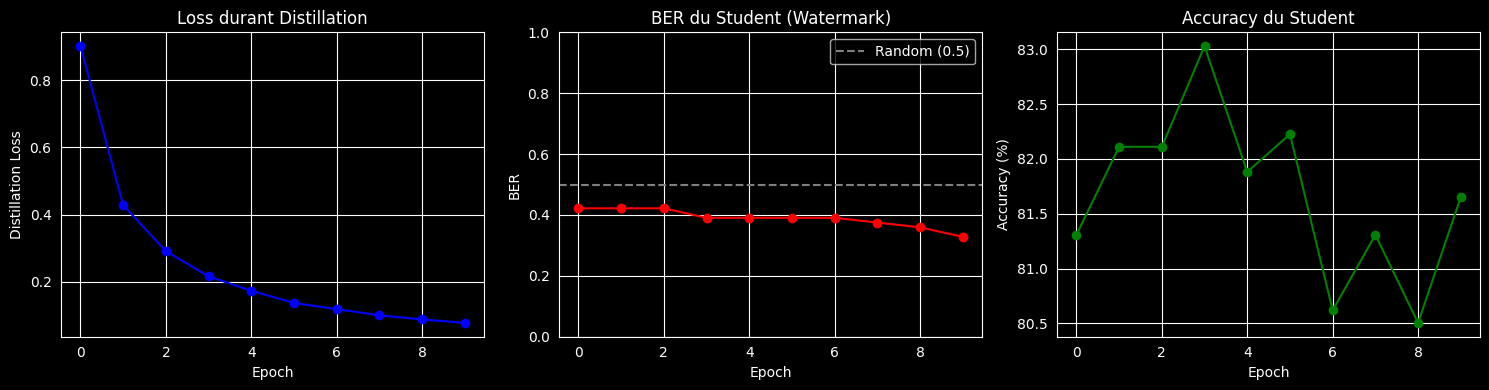


RESUME FINAL
BER Extrait : 0.00
BER Teacher (watermarke): 0.00
BER Student (apres distillation): 0.33
Accuracy Student: 81.7%

-> La marque Uchida a survecu a la distillation (BER faible)


In [7]:
# --- Visualisation des Resultats ---

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss
axes[0].plot(attack_history["loss"], 'b-o')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Distillation Loss")
axes[0].set_title("Loss durant Distillation")
axes[0].grid(True)

# BER
axes[1].plot(attack_history["ber"], 'r-o')
axes[1].axhline(y=0.5, color='gray', linestyle='--', label='Random (0.5)')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("BER")
axes[1].set_title("BER du Student (Watermark)")
axes[1].set_ylim([0, 1])
axes[1].legend()
axes[1].grid(True)

# Accuracy
axes[2].plot(attack_history["acc"], 'g-o')
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Accuracy (%)")
axes[2].set_title("Accuracy du Student")
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Resume final
print("\n" + "=" * 50)
print("RESUME FINAL")
print("=" * 50)
print(f"BER Teacher (watermarke): {uchida.extract(uchida.saved_keys['watermarked_model'])[0]:.2f}")
print(f"BER Student (apres distillation): {attack_history['ber'][-1]:.2f}")
print(f"Accuracy Student: {attack_history['acc'][-1]:.1f}%")

if attack_history['ber'][-1] > 0.4:
    print("\n-> La marque Uchida n'a PAS survecu a la distillation (BER eleve)")
else:
    print("\n-> La marque Uchida a survecu a la distillation (BER faible)")